In [1]:
# === Cell 1 — Imports, Datapaths & Params (FIXED) ===
from pathlib import Path
import numpy as np, pandas as pd, tifffile, matplotlib.pyplot as plt
from skimage import measure, segmentation
from tqdm.auto import tqdm
import motmetrics as mm

mm.lap.default_solver = 'lap'  # use 'lapjv' if installed

# --- Files ---
ROOT = Path.cwd()
DATA = ROOT / "DATA"
STACK = DATA / "position4_seg.tif"         # GT (channel 0)
NPZ   = DATA / "final_labels_both.npz"     # from tracking notebook

# --- Toggles / Params ---
# IMPORTANT: the evaluation MASK is now based on *validity* (>=0), not on foreground.
MASK_MODE   = 'intersection'               # 'gt' | 'pred' | 'union' | 'intersection'  (validity-based)
EVAL_FRAMES = 'good'             # 'good' | 'all'
GOOD_MINPX  = 1000               # min foreground pixels to consider a frame "good"
MAX_BAD_GAP = 2                  # gap split for ID metrics runs
DET_TAUS    = (0.5, 0.7)         # IoU thresholds for instance detection

# ID metrics (euclidean distance on centroids)
ID_METRIC    = 'euclidean'       # 'euclidean' only; IOU boxes require top-left boxes
ID_DIST_THR  = 14.0              # try 12–22 px (≈ 0.25–0.5 × cell diameter)

# SEG mode
SEG_MODE     = 'instance'              # 'fg' (foreground IoU) or 'instance' (mean IoU over GT instances)

print("Ready. MASK_MODE:", MASK_MODE, "| SEG_MODE:", SEG_MODE, "| ID_DIST_THR:", ID_DIST_THR)


Ready. MASK_MODE: intersection | SEG_MODE: instance | ID_DIST_THR: 14.0


In [2]:
# === Cell 2 — GT & Pred Loading (UNCHANGED) ===
stack = tifffile.imread(STACK)   # (T, 2, H, W)
gt_orig = stack[:100, 0]          # (T,H,W) labels: -1 undefined, 0 boundary, >0 cell ID
T, H, W = gt_orig.shape
print("GT shape:", gt_orig.shape)

npz = np.load(NPZ)
pred_orig = npz["final_labels_orig"]  # (T,H,W) int32: -1/0/>0 (IDs are global track IDs)
print("Pred shape:", pred_orig.shape, "| dtype:", pred_orig.dtype)


GT shape: (100, 1932, 1932)
Pred shape: (100, 1932, 1932) | dtype: int32


In [3]:
# === Cell 3 — Frame choosing for eval & split runs by gaps (UNCHANGED) ===
def is_good_frame_lab(lab2d):
    return np.count_nonzero(lab2d > 0) >= GOOD_MINPX

good_idx = [i for i in range(T) if is_good_frame_lab(gt_orig[i])]
eval_frames = good_idx if (EVAL_FRAMES == 'good') else list(range(T))
print(f"Evaluating on {len(eval_frames)} / {T} frames ({EVAL_FRAMES})")

# runs for ID metrics (split when bad-frame gap > MAX_BAD_GAP)
runs = []
if eval_frames:
    cur = [eval_frames[0]]
    for i in eval_frames[1:]:
        gap = i - cur[-1] - 1
        if gap > MAX_BAD_GAP:
            runs.append(cur); cur = [i]
        else:
            cur.append(i)
    runs.append(cur)

def summarize_runs(runs):
    if not runs: return "no runs"
    lens = [len(r) for r in runs]
    return f"{len(runs)} runs; lengths: min={min(lens)}, p50={np.median(lens):.1f}, max={max(lens)}"

print("runs:", summarize_runs(runs))
print([ (r[0], r[-1], len(r)) for r in runs ])


Evaluating on 93 / 100 frames (good)
runs: 1 runs; lengths: min=93, p50=93.0, max=93
[(0, 99, 93)]


In [4]:
# === Cell 4 — Helpers: validity-based mask & boundaries (FIXED) ===
def build_eval_mask_valid(gt_lab, pr_lab, mode='gt'):
    """
    Validity-based mask (not foreground-based):
      - valid GT:  gt_lab >= 0  (includes boundaries==0, excludes -1)
      - valid Pred: pr_lab >= 0
    This prevents degenerate IoU when using 'intersection'.
    """
    valid_gt = (gt_lab >= 0)
    valid_pr = (pr_lab >= 0)
    if mode == 'gt':
        return valid_gt
    elif mode == 'pred':
        return valid_pr
    elif mode == 'union':
        return valid_gt | valid_pr
    else:  # 'intersection'
        return valid_gt & valid_pr

def boundaries(img_bool):
    # True on outer boundary pixels (for overlays)
    return segmentation.find_boundaries(img_bool, mode='outer')


In [5]:
# === Cell 5 — SEG per frame (FIXED) ===
from scipy.optimize import linear_sum_assignment

def seg_fg_iou(gt_lab, pr_lab, M):
    gt_b = (gt_lab > 0) & M
    pr_b = (pr_lab > 0) & M
    inter = np.count_nonzero(gt_b & pr_b)
    union = np.count_nonzero(gt_b | pr_b)
    return inter / (union + 1e-9)

def seg_instance_mean(gt_lab, pr_lab, M):
    """Mean IoU over GT instances (unmatched GT contributes 0)."""
    gt = gt_lab.copy();  gt[~M] = 0
    pr = pr_lab.copy();  pr[~M] = 0
    if gt.max() <= 0:
        return 1.0 if pr.max() <= 0 else 0.0

    max_g, max_p = int(gt.max()), int(pr.max())
    overlap = np.zeros((max_g+1, max_p+1), dtype=np.int32)
    mask = (gt > 0) & (pr > 0)
    np.add.at(overlap, (gt[mask], pr[mask]), 1)

    g_sz = np.bincount(gt.ravel(), minlength=max_g+1)
    p_sz = np.bincount(pr.ravel(), minlength=max_p+1)
    iou = overlap / (g_sz[:,None] + p_sz[None,:] - overlap + 1e-9)

    gi = np.unique(gt)[1:]
    if iou.size == 0 or len(gi) == 0:
        return 0.0
    best = iou.max(axis=1)  # best match per GT index
    # Some label indices may be unused; select only existing GT labels:
    return float(best[gi].mean()) if gi.size else 1.0

seg_rows = []
for t in tqdm(eval_frames, desc="SEG"):
    M = build_eval_mask_valid(gt_orig[t], pred_orig[t], MASK_MODE)
    if SEG_MODE == 'instance':
        seg_val = seg_instance_mean(gt_orig[t], pred_orig[t], M)
    else:
        seg_val = seg_fg_iou(gt_orig[t], pred_orig[t], M)
    seg_rows.append(dict(frame=t, SEG=seg_val, SEG_mode=SEG_MODE))

seg_df = pd.DataFrame(seg_rows)


SEG:   0%|          | 0/93 [00:00<?, ?it/s]

In [6]:
# === Cell 6 — DET per frame (FIXED) ===
from scipy.optimize import linear_sum_assignment

def det_for_frame_labels(gt_lab, pr_lab, M, tau=0.5):
    # Keep original instance labels; zero outside M
    gt = gt_lab.copy();  gt[~M] = 0
    pr = pr_lab.copy();  pr[~M] = 0

    gi = np.unique(gt)[1:]  # skip 0
    pi = np.unique(pr)[1:]
    if len(gi)==0 and len(pi)==0:
        return dict(TP=0, FP=0, FN=0, DET=1.0)
    if len(gi)==0:
        return dict(TP=0, FP=len(pi), FN=0, DET=0.0)
    if len(pi)==0:
        return dict(TP=0, FP=0, FN=len(gi), DET=0.0)

    max_g, max_p = int(gt.max()), int(pr.max())
    overlap = np.zeros((max_g+1, max_p+1), dtype=np.int32)
    mask = (gt > 0) & (pr > 0)
    np.add.at(overlap, (gt[mask], pr[mask]), 1)

    g_sz = np.bincount(gt.ravel(), minlength=max_g+1)
    p_sz = np.bincount(pr.ravel(), minlength=max_p+1)
    iou = overlap / (g_sz[:,None] + p_sz[None,:] - overlap + 1e-9)

    # Hungarian on cost = 1 - IoU; disallow IoU < tau
    cost = 1.0 - iou
    cost[iou < tau] = 1e6
    ridx, cidx = linear_sum_assignment(cost)
    keep = cost[ridx, cidx] < 1e6
    TP = int(keep.sum())

    # FP: predicted objects that were never assigned
    assigned_p = np.zeros(max_p+1, dtype=bool)
    assigned_p[cidx[keep]] = True
    
    # After computing TP
    FP = int(len(pi) - TP)   # unmatched predicted instances in this frame
    
    # FN: GT objects that were not matched
    FN = int(len(gi) - TP) # unmatched GT instances in this frame

    det = TP / (TP + FP + FN + 1e-9)
    return dict(TP=TP, FP=FP, FN=FN, DET=det)

# Per-frame DET + micro-average aggregates
det_rows = []
det_micro = {f'TP@{tau}':0 for tau in DET_TAUS} | {f'FP@{tau}':0 for tau in DET_TAUS} | {f'FN@{tau}':0 for tau in DET_TAUS}

for t in tqdm(eval_frames, desc="DET"):
    M = build_eval_mask_valid(gt_orig[t], pred_orig[t], MASK_MODE)
    row = {'frame': t}
    for tau in DET_TAUS:
        r = det_for_frame_labels(gt_orig[t], pred_orig[t], M, tau=tau)
        row.update({f'DET@{tau}': r['DET'],
                    f'TP@{tau}': r['TP'],
                    f'FP@{tau}': r['FP'],
                    f'FN@{tau}': r['FN']})
        det_micro[f'TP@{tau}'] += r['TP']
        det_micro[f'FP@{tau}'] += r['FP']
        det_micro[f'FN@{tau}'] += r['FN']
    det_rows.append(row)

det_df = pd.DataFrame(det_rows)

# Compute micro-averaged DET across all frames
det_micro_avgs = {}
for tau in DET_TAUS:
    TP = det_micro[f'TP@{tau}']; FP = det_micro[f'FP@{tau}']; FN = det_micro[f'FN@{tau}']
    det_micro_avgs[f'DET_micro@{tau}'] = TP / (TP + FP + FN + 1e-9)

det_micro_avgs


DET:   0%|          | 0/93 [00:00<?, ?it/s]

{'DET_micro@0.5': 0.07846641194287722, 'DET_micro@0.7': 0.010336172508816193}

In [7]:
# === Cell 7 — results + save to CSV (FIXED) ===
all_df = det_df.merge(seg_df, on='frame', how='left')

avgs = {'SEG_mean': all_df['SEG'].mean()}
for tau in DET_TAUS:
    avgs[f'DET_mean@{tau}'] = all_df[f'DET@{tau}'].mean()
    avgs[f'DET_micro@{tau}'] = det_micro_avgs[f'DET_micro@{tau}']

print("Averages:", {k: round(v,3) for k,v in avgs.items()})
display(all_df.head(10))

OUT_DET_SEG = DATA / "metrics_det_seg_fixed.csv"
all_df.to_csv(OUT_DET_SEG, index=False)
print("wrote", OUT_DET_SEG)


Averages: {'SEG_mean': 0.365, 'DET_mean@0.5': 0.122, 'DET_micro@0.5': 0.078, 'DET_mean@0.7': 0.058, 'DET_micro@0.7': 0.01}


,frame,DET@0.5,TP@0.5,FP@0.5,FN@0.5,DET@0.7,TP@0.7,FP@0.7,FN@0.7,SEG,SEG_mode
0,0,0.990767,2468,19,4,0.989170,2466,21,6,0.900621,instance
1,1,0.048340,230,2235,2293,0.006863,34,2431,2489,0.320009,instance
2,2,0.037076,178,2289,2334,0.006062,30,2437,2482,0.316396,instance
3,3,0.094565,428,2022,2076,0.008345,41,2409,2463,0.359436,instance
4,4,0.089752,409,2059,2089,0.006282,31,2437,2467,0.357042,instance
5,5,0.074466,345,2110,2178,0.003427,17,2438,2506,0.341174,instance
6,6,0.091170,413,2037,2080,0.005902,29,2421,2464,0.355673,instance
7,7,0.077802,354,2080,2116,0.003479,17,2417,2453,0.342690,instance
8,8,0.085695,387,2059,2070,0.003890,19,2427,2438,0.352458,instance
9,9,0.076601,348,2083,2112,0.003282,16,2415,2444,0.339907,instance


wrote /Users/idanaviv/Downloads/final_project/implementation/DATA/metrics_det_seg_fixed.csv


In [8]:
# === Cell 8 — IDF1/MOTA via motmetrics (FIXED) ===
import time
from skimage.measure import regionprops_table
import motmetrics as mm

mm.lap.default_solver = 'lap'

# Precompute per-frame validity masks (same MASK_MODE)
M3 = np.zeros_like(gt_orig, dtype=bool)
for t in eval_frames:
    M3[t] = build_eval_mask_valid(gt_orig[t], pred_orig[t], MASK_MODE)

def build_mot_df_fast(labels_3d, frame_list, masks_3d=None):
    """
    Build MOT-format DF with centroids; applies mask (zero outside).
    Index: ['FrameId','Id']; columns: X, Y
    """
    rows = []
    for fr in frame_list:
        lab = labels_3d[fr].copy()
        if masks_3d is not None:
            lab[~masks_3d[fr]] = 0   # enforce evaluation mask
        lab[lab <= 0] = 0            # sanitize: background/undefined → 0
        if lab.max() == 0:
            continue
        props = regionprops_table(lab, properties=('label','centroid'))
        if len(props['label']) == 0:
            continue
        df = pd.DataFrame({
            'FrameId': fr,
            'Id'     : props['label'].astype(int),
            'X'      : props['centroid-1'].astype(float),
            'Y'      : props['centroid-0'].astype(float),
        })
        rows.append(df)
    if not rows:
        return pd.DataFrame(columns=['FrameId','Id','X','Y']).set_index(['FrameId','Id'])
    out = pd.concat(rows, ignore_index=True)
    return out.set_index(['FrameId','Id']).sort_index()

mh = mm.metrics.create()
dist_name   = 'EUC'  # centroid euclidean
dist_fields = ['X','Y']

runs_for_eval = runs if runs else [eval_frames]

all_summaries = []
t0 = time.time()
for i, frames_run in enumerate(tqdm(runs_for_eval, desc="ID metrics (runs)")):
    gt_df = build_mot_df_fast(gt_orig,   frames_run, masks_3d=M3)
    pr_df = build_mot_df_fast(pred_orig, frames_run, masks_3d=M3)

    if len(gt_df)==0 and len(pr_df)==0:
        continue

    acc = mm.utils.compare_to_groundtruth(
        gt_df, pr_df,
        dist=dist_name, distfields=dist_fields, distth=ID_DIST_THR
    )

    summ = mh.compute(
        acc,
        metrics=['num_frames','idf1','idp','idr','mota','motp','num_switches',
                 'mostly_tracked','mostly_lost','num_objects','num_predictions',
                 'precision','recall'],
        name=f'run{i}'
    )
    all_summaries.append(summ)

results_df = pd.concat(all_summaries) if all_summaries else pd.DataFrame()
print(f"done in {time.time()-t0:.2f} sec  |  metric={dist_name}  thr={ID_DIST_THR}")
display(results_df.round(3))

out_csv = DATA / "metrics_id_mota_fixed.csv"
if not results_df.empty:
    results_df.to_csv(out_csv)
    print("wrote", out_csv)


ID metrics (runs):   0%|          | 0/1 [00:00<?, ?it/s]

done in 50.92 sec  |  metric=EUC  thr=14.0


,num_frames,idf1,idp,idr,mota,motp,num_switches,mostly_tracked,mostly_lost,num_objects,num_predictions,precision,recall
run0,89,0.091,0.092,0.09,-0.296,8.987,25725,2401,5821,211631,207804,0.411,0.404


wrote /Users/idanaviv/Downloads/final_project/implementation/DATA/metrics_id_mota_fixed.csv


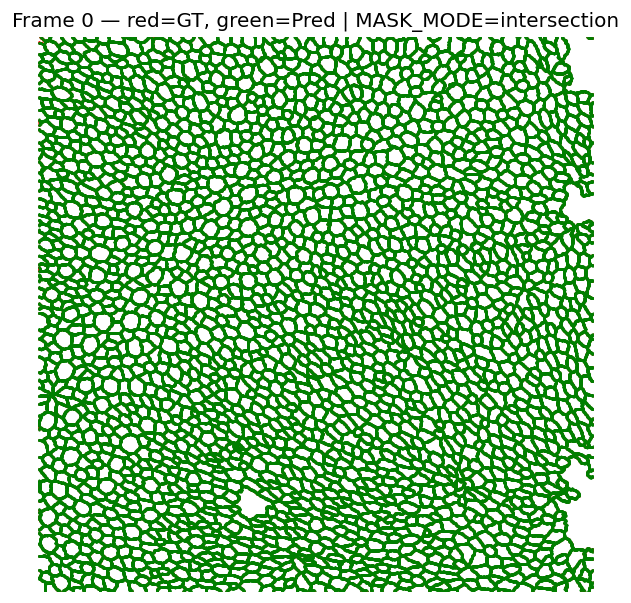

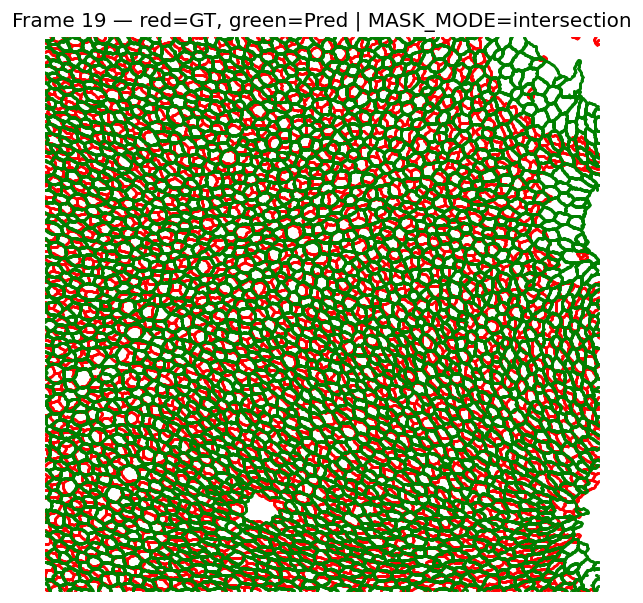

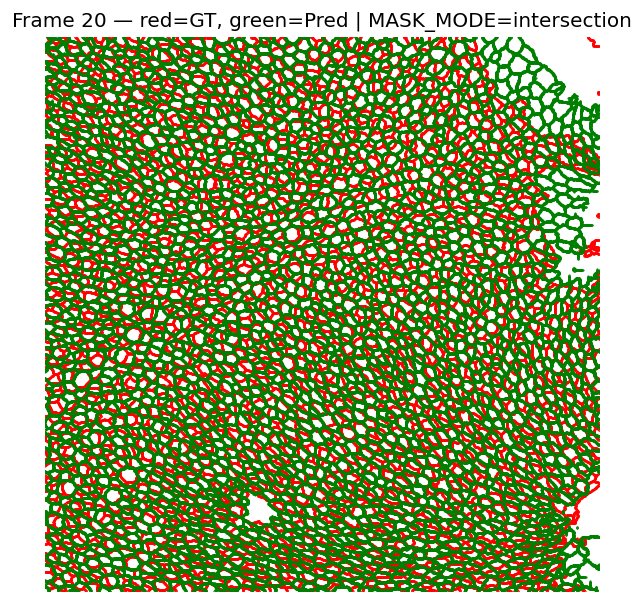

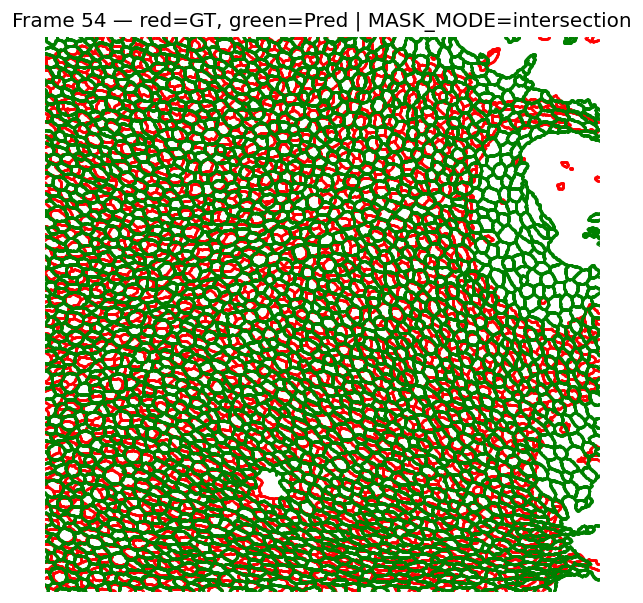

In [9]:
# === Cell 9 — Visual Boundary check (FIXED) ===
def show_overlay(t):
    M = build_eval_mask_valid(gt_orig[t], pred_orig[t], MASK_MODE)
    gt_b = (gt_orig[t]  > 0) & M
    pr_b = (pred_orig[t] > 0) & M

    plt.figure(figsize=(6,6), dpi=120)
    plt.imshow(M, cmap='gray', vmin=0, vmax=1)
    # red = GT boundaries; green = Pred boundaries
    yy,xx = np.where(boundaries(gt_b));  plt.scatter(xx,yy,s=0.1,c='r')
    yy,xx = np.where(boundaries(pr_b));  plt.scatter(xx,yy,s=0.1,c='g')
    plt.title(f"Frame {t} — red=GT, green=Pred | MASK_MODE={MASK_MODE}"); plt.axis('off')

# examples
for t in (0, 19, 20, 54):
    if t < T: show_overlay(t)


In [10]:
# === Cell 10 — Summary (FIXED) ===
print("=== Summary ===")
print(f"Frames evaluated: {len(eval_frames)} | MASK_MODE={MASK_MODE} | MAX_BAD_GAP={MAX_BAD_GAP} | SEG_MODE={SEG_MODE}")

# SEG & DET summaries
summary_dict = {'SEG_mean': float(seg_df['SEG'].mean())}
for tau in DET_TAUS:
    summary_dict[f'DET_mean@{tau}']  = float(det_df[f'DET@{tau}'].mean())
    summary_dict[f'DET_micro@{tau}'] = float(det_micro_avgs[f'DET_micro@{tau}'])

print("SEG/DET:", {k: round(v,3) for k,v in summary_dict.items()})

# ID metrics
if 'results_df' in globals() and isinstance(results_df, pd.DataFrame) and not results_df.empty:
    display(results_df.round(3))
else:
    print("(no ID metrics table to show — run Cell 8)")


=== Summary ===
Frames evaluated: 93 | MASK_MODE=intersection | MAX_BAD_GAP=2 | SEG_MODE=instance
SEG/DET: {'SEG_mean': 0.365, 'DET_mean@0.5': 0.122, 'DET_micro@0.5': 0.078, 'DET_mean@0.7': 0.058, 'DET_micro@0.7': 0.01}


,num_frames,idf1,idp,idr,mota,motp,num_switches,mostly_tracked,mostly_lost,num_objects,num_predictions,precision,recall
run0,89,0.091,0.092,0.09,-0.296,8.987,25725,2401,5821,211631,207804,0.411,0.404


In [11]:
# === OPTIONAL — quick sweep for ID_DIST_THR ===
sweep = []
for thr in [10, 12, 14, 16, 18, 20, 22]:
    mh = mm.metrics.create()
    rows = []
    for i, frames_run in enumerate(runs_for_eval):
        gt_df = build_mot_df_fast(gt_orig, frames_run, masks_3d=M3)
        pr_df = build_mot_df_fast(pred_orig, frames_run, masks_3d=M3)
        acc = mm.utils.compare_to_groundtruth(gt_df, pr_df, dist='EUC', distfields=['X','Y'], distth=thr)
        summ = mh.compute(acc, metrics=['idf1','mota','num_switches'], name=f'run{i}')
        rows.append(summ)
    tab = pd.concat(rows)
    sweep.append({'thr': thr, 'idf1': float(tab['idf1'].mean()), 'mota': float(tab['mota'].mean()),
                  'switches': float(tab['num_switches'].mean())})
sweep_df = pd.DataFrame(sweep)
print(sweep_df.round(3))


   thr   idf1   mota  switches
0   10  0.061 -0.622   15800.0
1   12  0.076 -0.471   20579.0
2   14  0.091 -0.296   25725.0
3   16  0.105 -0.111   30684.0
4   18  0.119  0.066   34650.0
5   20  0.134  0.219   37458.0
6   22  0.148  0.335   38788.0
